# EPA Vector Calibration Notebook

This notebook calibrates the EPA vectors from `epa_directions.pkl` using behavior-based prompts.

The goal is to fit a linear transformation from raw EPA readings to ACT dictionary values,
so that LLM-generated text can be accurately mapped to the EPA scale.

## Overview

1. Load the extracted EPA directions from Llama-3.1-8B-Instruct
2. Generate utterances that embody behaviors from the ACT dictionary
3. Read raw EPA values from these utterances using the extracted directions
4. Fit linear regression to map raw readings to dictionary EPA values
5. Evaluate calibration quality with R² scores

## 1. Setup and Imports

In [1]:
import sys
sys.path.append('../..')

import torch
import numpy as np
import pickle
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from repe import repe_pipeline_registry

# Register RepE pipelines
repe_pipeline_registry()

# Import ACT modules
from examples.act.act_core import EPA
from examples.act.epa_calibration import (
    BehaviorPromptGenerator,
    LinearRegressionCalibrator,
    AffineCalibrator,
    CalibrationCoefficients,
    CONVERSATIONAL_BEHAVIORS,
)
from examples.act.utils import (
    read_epa_scores,
    format_for_reading,
)

print("Modules loaded successfully!")

c:\Users\Kyra\mambaforge-pypy3\envs\repeng\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modules loaded successfully!


## 2. Load Model and EPA Directions

In [2]:
# Load the extracted EPA directions
directions_path = "epa_directions.pkl"

with open(directions_path, 'rb') as f:
    directions_data = pickle.load(f)

rep_readers = directions_data['rep_readers']
hidden_layers = directions_data['hidden_layers']
model_name = directions_data['model_name']

print(f"Loaded directions for model: {model_name}")
print(f"Dimensions available: {list(rep_readers.keys())}")
print(f"Number of layers: {len(hidden_layers)}")

Loaded directions for model: meta-llama/Llama-3.1-8B-Instruct
Dimensions available: ['evaluation', 'potency', 'activity']
Number of layers: 31


In [3]:
# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded: {model_name}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


Model loaded: meta-llama/Llama-3.1-8B-Instruct


In [4]:
# Create rep-reading pipeline
rep_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)
print("Rep-reading pipeline created!")

Device set to use cuda:0


Rep-reading pipeline created!


In [19]:
# Test user inputs with varying EPA
test_inputs = [
    # High Evaluation (Good)
    "Thank you so much for your help, I really appreciate everything you've done!",
    # Low Evaluation (Bad)
    "This is completely unacceptable and I'm disgusted by this behavior.",
    # High Potency (Dominant)
    "I demand that you fix this immediately. I won't tolerate any excuses.",
    # Low Potency (Submissive)
    "I'm sorry, if it's not too much trouble, could you maybe help me?",
    # High Activity (Energetic)
    "Oh my gosh, this is amazing! Let's go, let's go, let's go!",
    # Low Activity (Calm)
    "I suppose we could consider that option. There's no rush, take your time.",
    "Thank you so much, I really appreciate your help!",
]

# Use middle layers for reading (typically most informative)
reading_layers = hidden_layers[len(hidden_layers)//4:len(hidden_layers)*3//4]
# reading_layers = hidden_layers[-10:]
print(f"Using layers {reading_layers[:3]}...{reading_layers[-3:]} for reading")

Using layers [-8, -9, -10]...[-21, -22, -23] for reading


In [20]:
# Read EPA for each input
print("EPA Scores for Test Inputs:\n")
print(f"{'Input':<60} | {'E':>6} | {'P':>6} | {'A':>6}")
print("-" * 85)

all_scores = []
for user_input in test_inputs:
    scores = read_epa_scores(
        rep_pipeline,
        rep_readers,
        user_input,
        reading_layers,
    )
    all_scores.append(scores)
    
    truncated = user_input[:57] + "..." if len(user_input) > 60 else user_input
    print(f"{truncated:<60} | {scores['evaluation']:>6.2f} | {scores['potency']:>6.2f} | {scores['activity']:>6.2f}")

EPA Scores for Test Inputs:

Input                                                        |      E |      P |      A
-------------------------------------------------------------------------------------
Thank you so much for your help, I really appreciate ever... |   0.66 |  -0.36 |  -0.02
This is completely unacceptable and I'm disgusted by this... |  -0.11 |   0.05 |   0.40
I demand that you fix this immediately. I won't tolerate ... |  -0.77 |   0.86 |   1.18
I'm sorry, if it's not too much trouble, could you maybe ... |   0.20 |  -0.64 |  -0.61
Oh my gosh, this is amazing! Let's go, let's go, let's go!   |   0.07 |  -0.10 |   1.40
I suppose we could consider that option. There's no rush,... |   0.04 |  -0.27 |  -0.33
Thank you so much, I really appreciate your help!            |   0.46 |  -0.64 |  -0.19


## 3. Generate Calibration Data

We'll generate utterances that embody specific behaviors from the ACT dictionary,
then read their EPA values using the extracted directions.

In [5]:
# Initialize the behavior prompt generator
generator = BehaviorPromptGenerator()

print(f"Total behaviors in dictionary: {len(generator.behaviors)}")
print(f"Conversational behaviors available: {len(generator.available_behaviors)}")
print(f"\nSample behaviors: {generator.available_behaviors[:10]}")

Total behaviors in dictionary: 853
Conversational behaviors available: 85

Sample behaviors: ['accuse', 'admire', 'advise', 'agree_with', 'alarm', 'amaze', 'apologize_to', 'appeal_to', 'appreciate', 'argue_with']


In [6]:
# Show some behavior EPA values from the dictionary
print("Sample behavior EPA values from dictionary:")
print("-" * 50)
for behavior in ['thank', 'beg', 'threaten', 'comfort', 'criticize']:
    epa = generator.get_behavior_epa(behavior)
    if epa:
        print(f"{behavior:15} E={epa.e:+.2f} P={epa.p:+.2f} A={epa.a:+.2f}")

Sample behavior EPA values from dictionary:
--------------------------------------------------
thank           E=+3.18 P=+2.17 A=+0.78
beg             E=-1.42 P=-2.22 A=+0.81
threaten        E=-2.88 P=+0.73 A=+1.83
comfort         E=+3.11 P=+2.08 A=-0.72
criticize       E=-1.65 P=+0.07 A=+1.24


In [8]:
# Generate calibration pairs (utterance, target_EPA)
n_calibration_samples = 50  # Adjust based on available time/compute

calibration_pairs = generator.generate_calibration_pairs(
    n_samples=n_calibration_samples,
    behaviors=generator.available_behaviors[:20]  # Use first 20 behaviors with templates
)

print(f"Generated {len(calibration_pairs)} calibration pairs")
print("\nSample pairs:")
for utterance, target_epa in calibration_pairs[:3]:
    print(f"  '{utterance[:600]}...'")
    print(f"    Target: {target_epa}")

Generated 50 calibration pairs

Sample pairs:
  '[Expressing accuse]...'
    Target: EPA(e=-1.35, p=1.05, a=1.39)
  '[Expressing admire]...'
    Target: EPA(e=1.99, p=0.67, a=-0.26)
  '[Expressing advise]...'
    Target: EPA(e=2.10, p=1.61, a=0.30)


## 4. Read Raw EPA Values

Read the EPA values of each calibration utterance using the extracted directions.

In [22]:
def read_raw_epa(text: str) -> EPA:
    """
    Read raw EPA values from text using the extracted directions.
    
    Returns EPA object with raw (uncalibrated) values.
    """
    scores = read_epa_scores(
        pipeline=rep_pipeline,
        rep_readers=rep_readers,
        text=text,
        layers=hidden_layers[len(hidden_layers)//4:len(hidden_layers)*3//4],  # Use later layers (better representations)
        padding=True,
        truncation=True,
    )
    return EPA(
        e=scores.get('evaluation', 0.0),
        p=scores.get('potency', 0.0),
        a=scores.get('activity', 0.0)
    )

# Test with a sample
test_text = "Thank you so much, I really appreciate your help!"
test_epa = read_raw_epa(test_text)
print(f"Test text: '{test_text}'")
print(f"Raw EPA reading: {test_epa}")

Test text: 'Thank you so much, I really appreciate your help!'
Raw EPA reading: EPA(e=0.46, p=-0.64, a=-0.19)


In [23]:
# Read raw EPA values for all calibration utterances
print("Reading raw EPA values for calibration data...")
print("This may take a few minutes.")

raw_epas = []
target_epas = []
successful_pairs = []

for i, (utterance, target_epa) in enumerate(calibration_pairs):
    try:
        raw_epa = read_raw_epa(utterance)
        raw_epas.append(raw_epa.to_array())
        target_epas.append(target_epa.to_array())
        successful_pairs.append((utterance, target_epa, raw_epa))
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(calibration_pairs)}")
    except Exception as e:
        print(f"  Error processing '{utterance[:30]}...': {e}")

raw_epas = np.array(raw_epas)
target_epas = np.array(target_epas)

print(f"\nSuccessfully processed {len(raw_epas)} calibration samples")

Reading raw EPA values for calibration data...
This may take a few minutes.
  Processed 10/50
  Processed 20/50
  Processed 30/50
  Processed 40/50
  Processed 50/50

Successfully processed 50 calibration samples


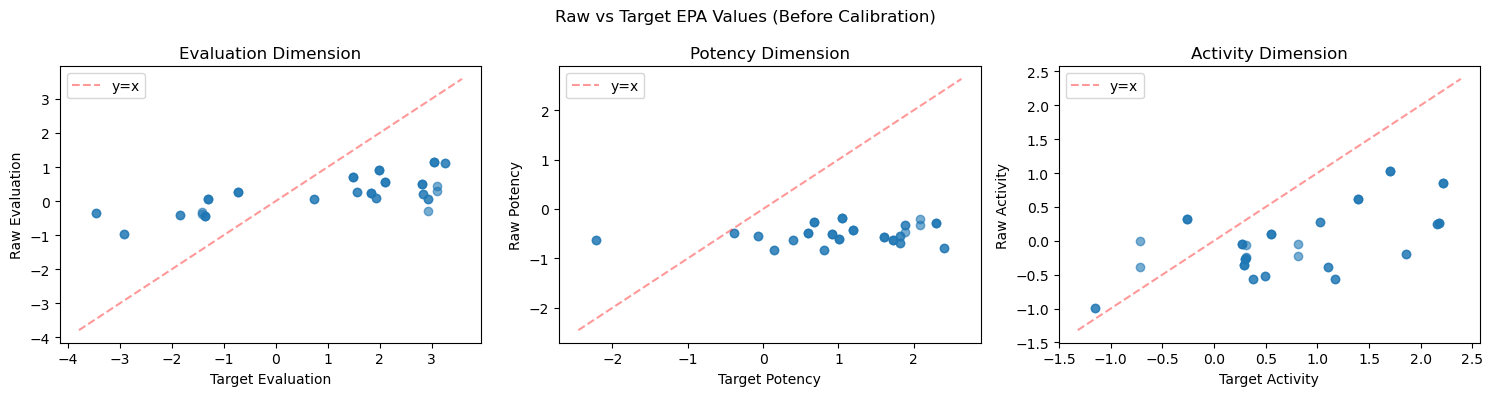

In [24]:
# Visualize raw vs target EPA distributions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
dim_names = ['Evaluation', 'Potency', 'Activity']

for i, (ax, name) in enumerate(zip(axes, dim_names)):
    ax.scatter(target_epas[:, i], raw_epas[:, i], alpha=0.6)
    ax.set_xlabel(f'Target {name}')
    ax.set_ylabel(f'Raw {name}')
    ax.set_title(f'{name} Dimension')
    
    # Add reference line
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'r--', alpha=0.4, label='y=x')
    ax.legend()

plt.suptitle('Raw vs Target EPA Values (Before Calibration)')
plt.tight_layout()
plt.savefig('calibration_before.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Fit Calibration

Fit linear regression to map raw EPA readings to target (dictionary) EPA values.

In [25]:
# Try different calibration methods
calibrators = {
    'linear': LinearRegressionCalibrator(),
    'ridge': LinearRegressionCalibrator(use_ridge=True, alpha=1.0),
    'affine': AffineCalibrator(regularization=0.01),
}

calibration_results = {}

for name, calibrator in calibrators.items():
    print(f"\n{'='*50}")
    print(f"Fitting {name} calibration...")
    print(f"{'='*50}")
    
    coefficients = calibrator.fit(raw_epas, target_epas)
    calibration_results[name] = coefficients
    
    print(f"\nR² Scores:")
    for dim, r2 in coefficients.r2_scores.items():
        print(f"  {dim}: {r2:.4f}")
    
    avg_r2 = np.mean(list(coefficients.r2_scores.values()))
    print(f"  Average: {avg_r2:.4f}")


Fitting linear calibration...

R² Scores:
  E: 0.6934
  P: 0.3250
  A: 0.6915
  Average: 0.5700

Fitting ridge calibration...

R² Scores:
  E: 0.6660
  P: 0.3072
  A: 0.6096
  Average: 0.5276

Fitting affine calibration...

R² Scores:
  E: 0.6934
  P: 0.3250
  A: 0.6915
  Average: 0.5700


In [26]:
# Select best calibration method based on average R²
best_method = max(
    calibration_results.keys(),
    key=lambda k: np.mean(list(calibration_results[k].r2_scores.values()))
)
best_coefficients = calibration_results[best_method]

print(f"Best calibration method: {best_method}")
print(f"R² scores: {best_coefficients.r2_scores}")

Best calibration method: linear
R² scores: {'E': 0.693375224333892, 'P': 0.32500678653721515, 'A': 0.6915369521429785}


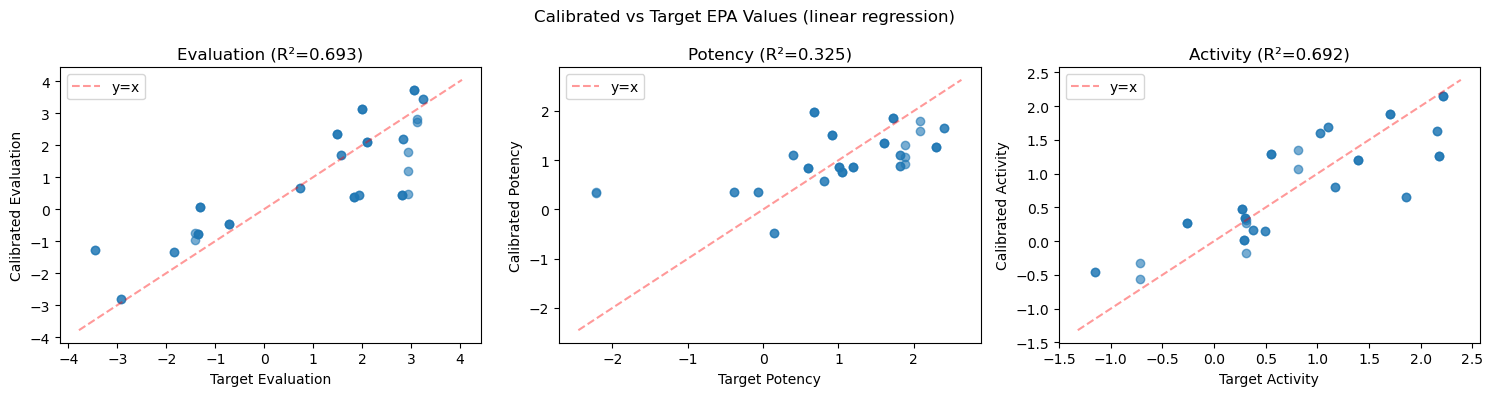

In [27]:
# Visualize calibrated vs target EPA distributions
calibrated_epas = np.array([best_coefficients.transform(raw) for raw in raw_epas])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (ax, name) in enumerate(zip(axes, dim_names)):
    ax.scatter(target_epas[:, i], calibrated_epas[:, i], alpha=0.6)
    ax.set_xlabel(f'Target {name}')
    ax.set_ylabel(f'Calibrated {name}')
    ax.set_title(f'{name} (R²={best_coefficients.r2_scores[name[0]]:0.3f})')
    
    # Add reference line
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'r--', alpha=0.4, label='y=x')
    ax.legend()

plt.suptitle(f'Calibrated vs Target EPA Values ({best_method} regression)')
plt.tight_layout()
plt.savefig('calibration_after.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Calibration Coefficients

In [28]:
# Save the best calibration
calibration_path = "epa_calibration.json"
best_coefficients.save(calibration_path)

print(f"Saved calibration to {calibration_path}")

# Verify by loading
loaded_coefficients = CalibrationCoefficients.load(calibration_path)
print(f"\nLoaded calibration:")
print(f"  Method: {loaded_coefficients.method}")
print(f"  R² Scores: {loaded_coefficients.r2_scores}")

Saved calibration to epa_calibration.json

Loaded calibration:
  Method: linear
  R² Scores: {'E': 0.693375224333892, 'P': 0.32500678653721515, 'A': 0.6915369521429785}


## 7. Test Calibration on New Examples

In [29]:
# Test utterances with expected EPA profiles
test_utterances = [
    ("Thank you so much for your help!", "Positive E, neutral P/A"),
    ("I demand you fix this immediately!", "Negative E, high P, high A"),
    ("Please, I'm begging you...", "Positive E, low P, neutral A"),
    ("You're absolutely terrible at this.", "Negative E, high P, high A"),
    ("It's okay, don't worry about it.", "Positive E, neutral/low P, low A"),
]

print("Testing calibration on new examples:")
print("=" * 70)

for utterance, expected in test_utterances:
    raw_epa = read_raw_epa(utterance)
    calibrated_epa = best_coefficients.to_epa(raw_epa)
    
    print(f"\nUtterance: '{utterance}'")
    print(f"Expected: {expected}")
    print(f"Raw EPA:       E={raw_epa.e:+.2f} P={raw_epa.p:+.2f} A={raw_epa.a:+.2f}")
    print(f"Calibrated:    E={calibrated_epa.e:+.2f} P={calibrated_epa.p:+.2f} A={calibrated_epa.a:+.2f}")

Testing calibration on new examples:

Utterance: 'Thank you so much for your help!'
Expected: Positive E, neutral P/A
Raw EPA:       E=+0.39 P=-0.66 A=-0.20
Calibrated:    E=+1.18 P=+1.02 A=+0.82

Utterance: 'I demand you fix this immediately!'
Expected: Negative E, high P, high A
Raw EPA:       E=-0.66 P=+0.09 A=+0.71
Calibrated:    E=-0.48 P=+0.98 A=+0.63

Utterance: 'Please, I'm begging you...'
Expected: Positive E, low P, neutral A
Raw EPA:       E=-0.72 P=-0.27 A=+0.25
Calibrated:    E=-1.16 P=+0.48 A=+0.95

Utterance: 'You're absolutely terrible at this.'
Expected: Negative E, high P, high A
Raw EPA:       E=-0.53 P=+0.09 A=+0.62
Calibrated:    E=+0.08 P=+1.15 A=+0.38

Utterance: 'It's okay, don't worry about it.'
Expected: Positive E, neutral/low P, low A
Raw EPA:       E=+0.10 P=-0.61 A=-0.58
Calibrated:    E=+1.42 P=+1.00 A=+0.08


## 8. Summary and Next Steps

### What we accomplished:
1. Loaded EPA directions extracted from Llama-3.1-8B-Instruct
2. Generated calibration data using behavior-based prompts
3. Fit linear regression to map raw readings to ACT scale
4. Evaluated calibration quality with R² scores
5. Saved calibration coefficients for use in steering

### Using the calibration:

```python
from examples.act.epa_calibration import CalibrationCoefficients
from examples.act.conversation_steering import ACTSteeringEngine

# Load calibration
calibration = CalibrationCoefficients.load("epa_calibration.json")

# Use with steering engine
engine = ACTSteeringEngine(
    agent_identity='assistant',
    user_identity='customer',
    calibration=calibration
)
```

In [ ]:
print("Calibration complete!")
print(f"\nOutput files:")
print(f"  - {calibration_path} (calibration coefficients)")
print(f"  - calibration_before.png (raw vs target)")
print(f"  - calibration_after.png (calibrated vs target)")

In [30]:
from examples.act.epa_calibration import CalibrationCoefficients
from examples.act.conversation_steering import ACTSteeringEngine

# Load calibration
calibration = CalibrationCoefficients.load("epa_calibration.json")

# Use with steering engine
engine = ACTSteeringEngine(
    agent_identity='assistant',
    user_identity='customer',
    calibration=calibration
)